In [1]:
import requests as req
from bs4 import BeautifulSoup as bs4
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import ElementNotInteractableException
from webdriver_manager.chrome import ChromeDriverManager

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression as LinReg, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from fake_useragent import UserAgent


In [2]:
df_unido = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_unido.csv")
df_unido2 = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_unido2.csv")
df_unido3 = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_unido3.csv")
df_final = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df_final.csv")

In [3]:
df_unido3

,Equipos,GP,Avg,0.5+,1.5+,2.5+,3.5+,4.5+,BTS,CS,FTS
0,BATE Borisov,6.0,4.33,100%,100%,83%,50%,50%,17%,0%,83%
1,Schalke 04,8.0,4.00,100%,88%,50%,50%,50%,62%,12%,25%
2,Sporting CP,6.0,4.00,100%,83%,67%,67%,33%,83%,0%,17%
3,Bayern Munich,12.0,3.83,92%,75%,67%,50%,42%,42%,50%,17%
4,Galatasaray,6.0,3.83,100%,100%,67%,67%,50%,67%,0%,33%
...,...,...,...,...,...,...,...,...,...,...,...
251,AC Milan,12.0,2.17,92%,67%,33%,25%,0%,25%,42%,42%
252,FC Kobenhavn,6.0,2.17,67%,67%,50%,17%,17%,17%,33%,83%
253,Chelsea,10.0,2.10,100%,80%,30%,0%,0%,30%,30%,40%
254,Leverkusen,6.0,2.00,83%,67%,33%,17%,0%,17%,33%,67%


In [4]:
df_copy2 = df_unido3.copy()

In [5]:
cols_a_convertir = ['0.5+', '1.5+', '2.5+', '3.5+', '4.5+', 'BTS', 'CS', 'FTS']
df_copy2[cols_a_convertir] = df_copy2[cols_a_convertir].replace('%', '', regex=True).astype(float) / 100

In [6]:
corr=df_copy2.corr(numeric_only=True)
corr

,GP,Avg,0.5+,1.5+,2.5+,3.5+,4.5+,BTS,CS,FTS
GP,1.000000,-0.014609,-0.049551,-0.098827,-0.003452,-0.010154,0.010708,-0.072744,0.563144,-0.429222
Avg,-0.014609,1.000000,0.544039,0.729847,0.777624,0.830478,0.794669,0.546113,-0.393480,-0.416647
0.5+,-0.049551,0.544039,1.000000,0.629874,0.458755,0.262869,0.229772,0.375598,-0.537072,-0.307869
1.5+,-0.098827,0.729847,0.629874,1.000000,0.641666,0.447335,0.389264,0.583041,-0.479758,-0.409978
2.5+,-0.003452,0.777624,0.458755,0.641666,1.000000,0.620876,0.424078,0.510746,-0.334965,-0.398749
3.5+,-0.010154,0.830478,0.262869,0.447335,0.620876,1.000000,0.699110,0.448914,-0.249555,-0.331748
4.5+,0.010708,0.794669,0.229772,0.389264,0.424078,0.699110,1.000000,0.341028,-0.203793,-0.251758
BTS,-0.072744,0.546113,0.375598,0.583041,0.510746,0.448914,0.341028,1.000000,-0.509984,-0.692305
CS,0.563144,-0.393480,-0.537072,-0.479758,-0.334965,-0.249555,-0.203793,-0.509984,1.000000,-0.185358
FTS,-0.429222,-0.416647,-0.307869,-0.409978,-0.398749,-0.331748,-0.251758,-0.692305,-0.185358,1.000000


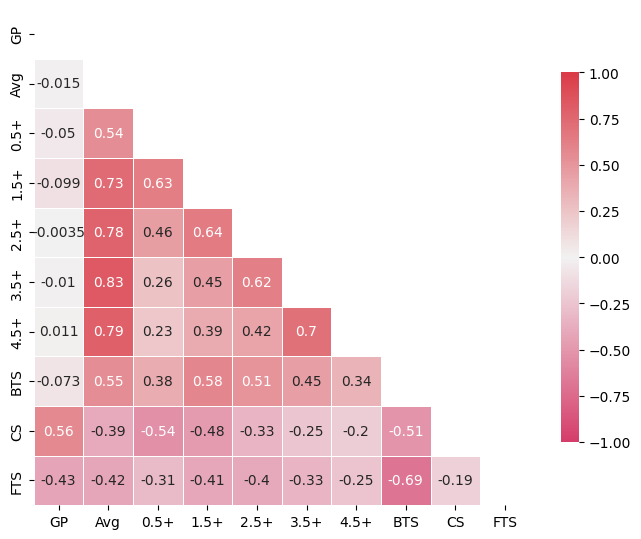

In [7]:
fig, ax=plt.subplots(figsize=(8,8))

mask=np.triu(np.ones_like(corr, dtype=bool))

color_map=sns.diverging_palette(0, 10, as_cmap=True)

# Heatmap
sns.heatmap(corr,                       # datos
            mask=mask,                  # mascara
            cmap=color_map,             # color
            vmax=1,
            vmin=-1, #QUE ALGUINE PREGUNTÓ EL OTRO DíA PERO AL FINAL NO LO CAMBIAMOS
            #center=0,                  # valor central
            square=True,
            annot=True,
            linewidth=.5,
            cbar_kws={'shrink': .6},
            ax=ax                       # eje
           );

In [8]:
#Voy a coger todas las columnas que son numéricas y estandarizarlas
data_num=pd.DataFrame(StandardScaler().fit_transform(df_copy2._get_numeric_data()),
                      columns=df_copy2._get_numeric_data().columns)

#Voy a coger todas columnas que son categóricas
data_obj=df_copy2.select_dtypes(include='object')

#Junto todas de nuevo
data = pd.concat([data_num, data_obj], axis=1)
data.head()

,GP,Avg,0.5+,1.5+,2.5+,3.5+,4.5+,BTS,CS,FTS,Equipos
0,-0.808367,1.805388,0.686479,1.198924,1.375245,0.829678,2.023974,-1.548401,-1.299805,2.457015,BATE Borisov
1,0.083624,1.365128,0.686479,0.439993,-0.331538,0.829678,2.023974,0.584515,-0.687475,-0.292797,Schalke 04
2,-0.808367,1.365128,0.686479,0.123771,0.547714,1.729893,0.944653,1.579876,-1.299805,-0.672082,Sporting CP
3,1.867607,1.138328,-0.193314,-0.382183,0.547714,0.829678,1.516058,-0.363447,1.251568,-0.672082,Bayern Munich
4,-0.808367,1.138328,0.686479,1.198924,0.547714,1.729893,2.023974,0.821506,-1.299805,0.086487,Galatasaray


In [9]:
#Quitamos los Churns y tb el CustomerID, que ese fijo que no influye
X = data.drop(columns = ['GP','Equipos'])

y = data['GP']

In [10]:
linreg = LinReg()

lasso = Lasso()

ridge = Ridge()

elastic = ElasticNet()

In [11]:
X_train, X_test, y_train, y_test = tts(X, y,
                                       random_state=42,
                                       test_size = 0.1,
                                       stratify=y)

In [12]:
linreg.fit(X_train, y_train)

LinearRegression()

In [13]:
linreg.intercept_    

-0.0017504402480967244

In [14]:
linreg.coef_        # betas, desde 1 a N

array([ 0.00814196, -0.63870975, -0.09618529,  0.02313528, -0.02116324,
        0.06320358, -2.03279076, -1.24404407, -2.28341517])

In [15]:
df3_2024 = pd.read_csv(r"C:\Users\Aleja\OneDrive\Documentos\PROYECTO2\df3_2024.csv")
df3_2024.head()

,Matches of...,GP,Avg,0.5+,1.5+,2.5+,3.5+,4.5+,BTS,CS,FTS
0,Manchester Utd,6.0,4.50,100%,67%,67%,67%,67%,67%,17%,17%
1,Manchester City,7.0,4.14,100%,100%,100%,86%,29%,86%,14%,0%
2,Antwerp,6.0,3.83,100%,83%,67%,67%,67%,50%,0%,50%
3,Galatasaray,6.0,3.83,100%,83%,83%,67%,33%,83%,0%,17%
4,Red Star,6.0,3.67,100%,100%,83%,67%,17%,83%,0%,17%


In [16]:
cols_a_convertir = ['0.5+', '1.5+', '2.5+', '3.5+', '4.5+', 'BTS', 'CS', 'FTS']
df3_2024[cols_a_convertir] = df_copy2[cols_a_convertir].replace('%', '', regex=True).astype(float) / 100

In [17]:
corr=df3_2024.corr(numeric_only=True)
corr

,GP,Avg,0.5+,1.5+,2.5+,3.5+,4.5+,BTS,CS,FTS
GP,1.000000,-0.226652,-0.080427,0.058065,-0.398587,-0.389652,-0.137134,0.115108,0.051141,-0.132721
Avg,-0.226652,1.000000,0.656221,0.741233,0.805038,0.813790,0.813081,0.505998,-0.511744,-0.278281
0.5+,-0.080427,0.656221,1.000000,0.754856,0.623795,0.501041,0.277019,0.623963,-0.704728,-0.386268
1.5+,0.058065,0.741233,0.754856,1.000000,0.667101,0.535875,0.536220,0.652320,-0.548166,-0.461307
2.5+,-0.398587,0.805038,0.623795,0.667101,1.000000,0.721125,0.496886,0.520733,-0.386848,-0.428679
3.5+,-0.389652,0.813790,0.501041,0.535875,0.721125,1.000000,0.685939,0.512608,-0.401001,-0.352057
4.5+,-0.137134,0.813081,0.277019,0.536220,0.496886,0.685939,1.000000,0.354012,-0.331739,-0.163539
BTS,0.115108,0.505998,0.623963,0.652320,0.520733,0.512608,0.354012,1.000000,-0.573518,-0.737956
CS,0.051141,-0.511744,-0.704728,-0.548166,-0.386848,-0.401001,-0.331739,-0.573518,1.000000,-0.078590
FTS,-0.132721,-0.278281,-0.386268,-0.461307,-0.428679,-0.352057,-0.163539,-0.737956,-0.078590,1.000000


In [18]:
#Voy a coger todas las columnas que son numéricas y estandarizarlas
data_num2=pd.DataFrame(StandardScaler().fit_transform(df3_2024._get_numeric_data()),
                      columns=df3_2024._get_numeric_data().columns)

#Voy a coger todas columnas que son categóricas
data_obj2=df3_2024.select_dtypes(include='object')

#Junto todas de nuevo
data2 = pd.concat([data_num2, data_obj2], axis=1)
data2.head()

,GP,Avg,0.5+,1.5+,2.5+,3.5+,4.5+,BTS,CS,FTS,Matches of...
0,-1.0,2.226356,0.607628,1.074969,1.842940,0.722671,1.595696,-1.360385,-1.203900,2.286916,Manchester Utd
1,1.0,1.694579,0.607628,0.498639,0.046434,0.722671,1.595696,0.646741,-0.642539,-0.348852,Manchester City
2,-1.0,1.236659,0.607628,0.258501,0.971907,1.652970,0.655520,1.583399,-1.203900,-0.712406,Antwerp
3,-1.0,1.236659,-0.231331,-0.125719,0.971907,0.722671,1.153260,-0.245315,1.135106,-0.712406,Galatasaray
4,-1.0,1.000314,0.607628,1.074969,0.971907,1.652970,1.595696,0.869755,-1.203900,0.014703,Red Star


In [19]:
data2.dropna(inplace=True)

In [20]:
data2.drop(columns = ['GP','Matches of...'],inplace=True)

In [21]:
puntaje = linreg.predict(data2)
puntaje

array([-1.30581736, -0.05614805, -0.47000604,  0.96151695, -0.70063996,
       -0.07008997,  0.946242  , -0.76639479,  0.44547785,  0.92902092,
        0.23585846,  1.18579306, -0.70409445, -0.21103566, -0.75561644,
       -0.21424345, -0.11660285,  0.44887304,  0.19120099, -0.75064497,
        1.37530434, -0.0153431 , -0.11716611, -0.92071756, -1.3149072 ,
        0.49834543,  1.1574585 ,  0.60497912,  0.26977575,  0.03802674,
       -0.28688765,  0.30091836])

In [22]:
df_predict2 = pd.DataFrame({'Probabilidad': puntaje})

In [23]:
df_ML2 = pd.concat([df3_2024,df_predict2],axis=1).sort_values(by = 'Probabilidad',ascending=False)
df_ML2.reset_index(inplace=True)
df_ML2.drop(columns=['index'],inplace=True)

In [5]:
df_ML = pd.read_csv("C:/Users/Aleja/OneDrive/Documentos/PROYECTO2/df_ML")
df_ML

,Equipo,GP,W,D,L,GF,GA,GD,Pts,PPG,CS,FTS,Probabilidad
0,Manchester City,8,8,0,0,24,9,15,24,3.00,12%,0%,1.81%
1,Real Madrid,8,7,1,0,18,8,10,22,2.75,38%,0%,1.76%
2,Bayern Munich,8,6,1,1,15,7,8,19,2.38,38%,25%,1.31%
3,Inter Milan,8,4,3,1,10,7,3,15,1.88,50%,12%,1.02%
4,Atletico Madrid,8,5,2,1,19,8,11,17,2.13,25%,12%,0.99%
5,Dortmund,8,4,3,1,10,5,5,15,1.88,50%,25%,0.95%
6,FC Barcelona,8,5,1,2,16,8,8,16,2.00,25%,12%,0.85%
7,Arsenal,8,5,1,2,17,5,12,16,2.00,50%,12%,0.81%
8,Paris SG,8,4,2,2,13,9,4,14,1.75,38%,0%,0.77%
9,Lazio,8,4,1,3,8,10,-2,13,1.63,38%,25%,0.66%
